### Import main functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, copy
%matplotlib inline

imw = 192
imh = 192
c = 1
RS = 2211

In [2]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [3]:
from plot_helpers import show_image, plot_clusters
from dataset_helpers import is_dmso, get_label
from dataset_helpers import low_clip, mean_clip, low_clip, minmax, max_normalise

In [4]:
from sklearn.manifold import TSNE
import umap
from keras.layers import Input, BatchNormalization, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Flatten, Reshape, LeakyReLU
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.


In [5]:
def unishuffle(a, b, random_state=RS):
    assert len(a) == len(b)
    if random_state:
        np.random.seed(RS)
    p = np.random.permutation(len(a))
    return a[p], b[p]

### Read dataset

In [6]:
npzfile = np.load('/Users/Leonore/Desktop/dmso_unmodified.npz')

In [7]:
y = npzfile['y']

In [8]:
y_dmso = np.array([get_label(i) for i in y])

In [9]:
X = npzfile['x']

In [41]:
for idx,image in enumerate(X):
    if np.min(image) != 0:
        print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
2

2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419


4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579


6642
6643
6644
6645
6646
6647
6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681
6682
6683
6684
6685
6686
6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704
6705
6706
6707
6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841


8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682


10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330
10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481
10482
10483
10484
10485
1048

11998
11999
12000
12001
12002
12003
12004
12005
12006
12007
12008
12009
12010
12011
12012
12013
12014
12015
12016
12017
12018
12019
12020
12021
12022
12023
12024
12025
12026
12027
12028
12029
12030
12031
12032
12033
12034
12035
12036
12037
12038
12039
12040
12041
12042
12043
12044
12045
12046
12047
12048
12049
12050
12051
12052
12053
12054
12055
12056
12057
12058
12059
12060
12061
12062
12063
12064
12065
12066
12067
12068
12069
12070
12071
12072
12073
12074
12075
12076
12077
12078
12079
12080
12081
12082
12083
12084
12085
12086
12087
12088
12089
12090
12091
12092
12093
12094
12095
12096
12097
12098
12099
12100
12101
12102
12103
12104
12105
12106
12107
12108
12109
12110
12111
12112
12113
12114
12115
12116
12117
12118
12119
12120
12121
12122
12123
12124
12125
12126
12127
12128
12129
12130
12131
12132
12133
12134
12135
12136
12137
12138
12139
12140
12141
12142
12143
12144
12145
12146
12147
12148
12149
12150
12151
12152
12153
12154
12155
12156
12157
12158
12159
12160
12161
12162
12163
1216

13672
13673
13674
13675
13676
13677
13678
13679
13680
13681
13682
13683
13684
13685
13686
13687
13688
13689
13690
13691
13692
13693
13694
13695
13696
13697
13698
13699
13700
13701
13702
13703
13704
13705
13706
13707
13708
13709
13710
13711
13712
13713
13714
13715
13716
13717
13718
13719
13720
13721
13722
13723
13724
13725
13726
13727
13728
13729
13730
13731
13732
13733
13734
13735
13736
13737
13738
13739
13740
13741
13742
13743
13744
13745
13746
13747
13748
13749
13750
13751
13752
13753
13754
13755
13756
13757
13758
13759
13760
13761
13762
13763
13764
13765
13766
13767
13768
13769
13770
13771
13772
13773
13774
13775
13776
13777
13778
13779
13780
13781
13782
13783
13784
13785
13786
13787
13788
13789
13790
13791
13792
13793
13794
13795
13796
13797
13798
13799
13800
13801
13802
13803
13804
13805
13806
13807
13808
13809
13810
13811
13812
13813
13814
13815
13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832
13833
13834
13835
13836
13837
1383

15523
15524
15525
15526
15527
15528
15529
15530
15531
15532
15533
15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
1568

17229
17230
17231
17232
17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
17243
17244
17245
17246
17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
17257
17258
17259
17260
17261
17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273
17274
17275
17276
17277
17278
17279
17280
17281
17282
17283
17284
17285
17286
17287
17288
17289
17290
17291
17292
17293
17294
17295
17296
17297
17298
17299
17300
17301
17302
17303
17304
17305
17306
17307
17308
17309
17310
17311
17312
17313
17314
17315
17316
17317
17318
17319
17320
17321
17322
17323
17324
17325
17326
17327
17328
17329
17330
17331
17332
17333
17334
17335
17336
17337
17338
17339
17340
17341
17342
17343
17344
17345
17346
17347
17348
17349
17350
17351
17352
17353
17354
17355
17356
17357
17358
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368
17369
17370
17371
17372
17373
17374
17375
17376
17377
17378
17379
17380
17381
17382
17383
17384
17385
17386
17387
17388
17389
17390
17391
17392
17393
17394
1739

18923
18924
18925
18926
18927
18928
18929
18930
18931
18932
18933
18934
18935
18936
18937
18938
18939
18940
18941
18942
18943
18944
18945
18946
18947
18948
18949
18950
18951
18952
18953
18954
18955
18956
18957
18958
18959
18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971
18972
18973
18974
18975
18976
18977
18978
18979
18980
18981
18982
18983
18984
18985
18986
18987
18988
18989
18990
18991
18992
18993
18994
18995
18996
18997
18998
18999
19000
19001
19002
19003
19004
19005
19006
19007
19008
19009
19010
19011
19012
19013
19014
19015
19016
19017
19018
19019
19020
19021
19022
19023
19024
19025
19026
19027
19028
19029
19030
19031
19032
19033
19034
19035
19036
19037
19038
19039
19040
19041
19042
19043
19044
19045
19046
19047
19048
19049
19050
19051
19052
19053
19054
19055
19056
19057
19058
19059
19060
19061
19062
19063
19064
19065
19066
19067
19068
19069
19070
19071
19072
19073
19074
19075
19076
19077
19078
19079
19080
19081
19082
19083
19084
19085
19086
19087
19088
1908

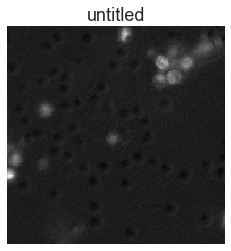

In [47]:
show_image(X[19586])

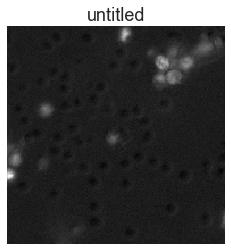

In [48]:
show_image(max_normalise(X[19586]))

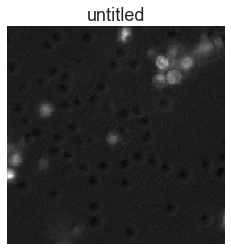

In [49]:
show_image(minmax(X[19586]))

In [53]:
max_normalise(X[19586]).min()

0.30980393

In [54]:
minmax(X[19586]).min()

0.0

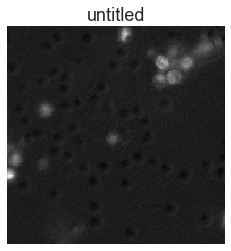

In [50]:
show_image(low_clip(X[19586]))

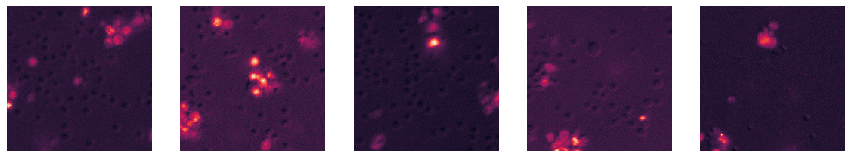

In [42]:
plot_range(X, rn=19585)

In [44]:
X[19585].max()

1137.0

In [15]:
def plot_range(imgs, rn=8):
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, 6):
        ax = fig.add_subplot(1, 5, i)
        plt.imshow(imgs[i+rn])
        ax.axis('off')

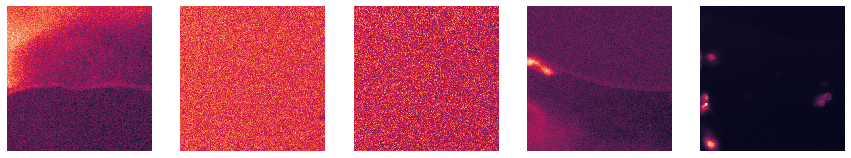

In [37]:
plot_range(X, rn=983)

In [38]:
y[983]

'/Volumes/TARDIS/CK19/CK19 - N - 5(fld 1 wv TexasRed - TexasRed).tif'

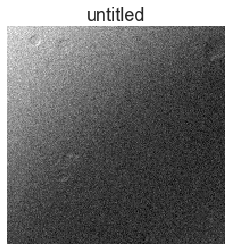

In [20]:
show_image(X[55]/np.max(X[55]))

### Helper functions for evaluating model

In [9]:
plt.rcParams.update({'axes.titlesize': 'medium'})

def run_evaluation(model, data, test, batch_size=48, epochs=30, visualise=False):
    # visualise feature maps
    if visualise:
        visualise_activations(model, data)
    
    # get model image predictions before training
    # @QUESTION: is this a good strategy?
    decoded_before = model.predict(data[21:22])
    test_decoded_before = model.predict(test[21:22])

    # fit model; get before/after weights (make sure there is a change)
    untrained_weights = [np.min(model.get_layer(index=1).get_weights()[0]), np.max(model.get_layer(index=1).get_weights()[0])]
    loss = model.fit(data, data, epochs=epochs, batch_size=batch_size)
    trained_weights = [np.min(model.get_layer(index=1).get_weights()[0]), np.max(model.get_layer(index=1).get_weights()[0])]
    
    # plot the loss
    plt.figure()
    plt.plot(loss.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    
    
    # show the difference in reconstruction
    decoded_imgs = model.predict(data[21:22]) # test on images it trained on
    untrained_decoded = model.predict(test[21:22]) # test images

    s=12
    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 3, 1)
    show_image(reshape(data[21], w=imw, h=imh, c=c), "original training image")
    fig.add_subplot(1, 3, 2)
    show_image(reshape(decoded_imgs[0], w=imw, h=imh, c=c), "reconstructed - after")
    fig.add_subplot(1, 3, 3)
    show_image(reshape(decoded_before[0], w=imw, h=imh, c=c), "reconstructed - before")

    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 3, 1)
    show_image(reshape(test[21], w=imw, h=imh, c=c), "original test image")
    fig.add_subplot(1, 3, 2)
    show_image(reshape(untrained_decoded[0], w=imw, h=imh, c=c), "reconstructed test - after")
    fig.add_subplot(1, 3, 3)
    show_image(reshape(test_decoded_before[0], w=imw, h=imh, c=c), "reconstructed test - before")
              
    # see if weights have changed
    print("Weight difference: {}".format(np.array(untrained_weights)-np.array(trained_weights)))

In [10]:
# credit: https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

def visualise_activations(model, images):
    idx = np.random.randint(1, len(images)+1)
    l = len(model.layers)
    layer_outputs = [layer.output for layer in model.layers[1:l]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    # Choose random image to predict for
    activations = activation_model.predict(images[idx-1:idx])

    layer_names = []
    for layer in model.layers[1:l]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                              :, :,
                                              col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 65535).astype('uint16')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                          row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

### Human visualisation of different drug conditions

In [15]:
def plot_range(imgs, rn=8):
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, 6):
        ax = fig.add_subplot(1, 5, i)
        plt.imshow(imgs[i+rn])
        ax.axis('off')

In [27]:
X = npzfile['x']

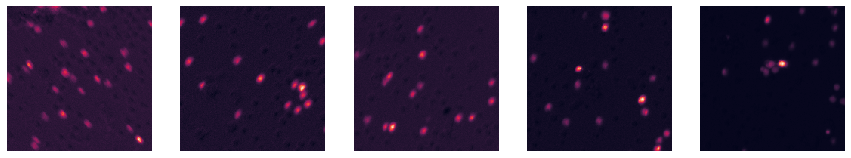

In [18]:
plot_range(X)

In [19]:
maxd = np.max(X)

In [21]:
X_12bit = X / maxd

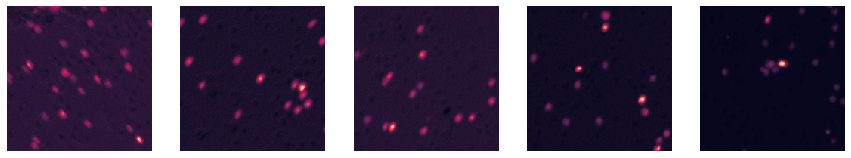

In [22]:
plot_range(X_12bit)

In [25]:
c=3
idx = 0
j = 0
x_combined = np.ndarray(shape=(len(X)//2, 192, 192, c))
y_combined = np.ndarray(shape=(len(X)//2))
while idx < (len(X)):
    if (idx % 100 == 0) and (idx % 200 != 0):
        idx += 100
    else:
        x_combined[j, :, :, 0] = X[idx] / maxd
        x_combined[j, :, :, 1] = X[idx+100] / maxd
        y_combined[j] = y_dmso[idx]
        idx+=1
        j+=1

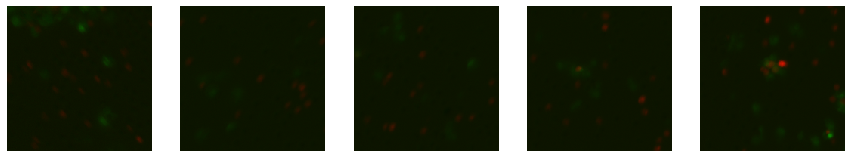

In [26]:
plot_range(x_combined)

In [28]:
c=3
idx = 0
j = 0
X_cc = np.ndarray(shape=(len(X)//2, 192, 192, c))
y_cc = np.ndarray(shape=(len(X)//2))
while idx < (len(X)):
    if (idx % 100 == 0) and (idx % 200 != 0):
        idx += 100
    else:
        X_cc[j, :, :, 0] = low_clip(X[idx]) / maxd
        X_cc[j, :, :, 1] = low_clip(X[idx+100]) / maxd
        y_cc[j] = y_dmso[idx]
        idx+=1
        j+=1

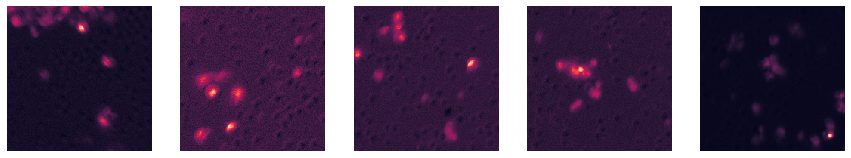

In [32]:
plot_range(X_cc[:,:,:,1])

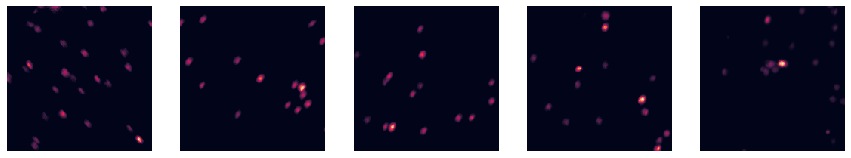

In [33]:
plot_range(X_cc[:,:,:,0])

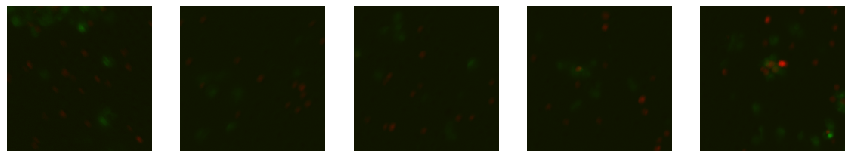

In [34]:
plot_range(X_cc)

In [ ]:
X = npzfile['x']
idx = 0
j = 0
X_cc2 = np.ndarray(shape=(len(X)//2, 192, 192, c))
y_cc2 = np.ndarray(shape=(len(X)//2))
while idx < (len(X)):
    if (idx % 100 == 0) and (idx % 200 != 0):
        idx += 100
    else:
        X_cc2[j, :, :, 0] = max_normalise(X[idx])
        X_cc2[j, :, :, 1] = max_normalise(X[idx+100])
        y_cc2[j] = y_dmso[idx]
        idx+=1
        j+=1

In [ ]:
plot_range(X_cc2)

In [0]:
unstimulated = x_combined[y_combined==0]

In [0]:
ova = x_combined[y_combined==1]

In [0]:
cona = x_combined[y_combined==2]

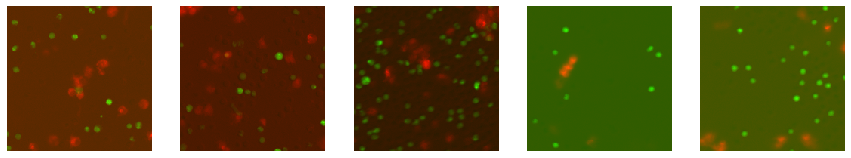

In [0]:
plot_range(unstimulated, rn=9)

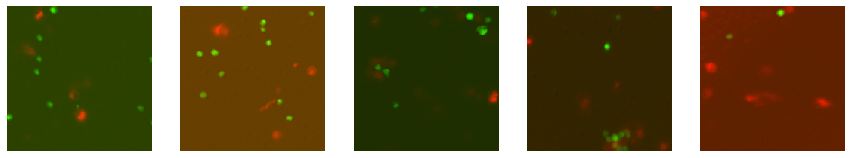

In [0]:
plot_range(ova, rn=9)

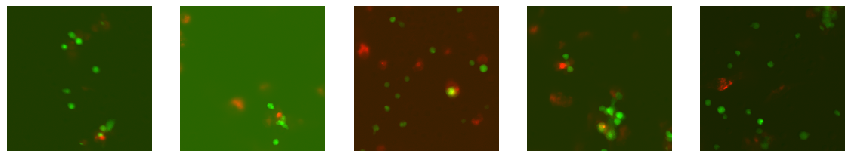

In [0]:
plot_range(cona, rn=9)